# Tarefa 2 - Parte 2
MO444A - Aprendizado de Máquina e Reconhecimento de Padrões

> Aplicação de métodos de aprendizado supervisionado para resolver problemas de predição e classificação

__Alunos__:

- Leonardo Augusto Silva Bernardes - RA: 233548<br>
Desenvolveu a parte 2 do trabalho e revisou a parte 1.


- Yan Prada - RA: 118982<br>
Desenvolveu a parte 1 do trabalho e revisou a parte 2.

Tivemos reuniões para que cada um explicasse o que estava fazendo, enquanto o outro sugerisse ou resolvesse dúvidas pendentes.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

- __Carregando o dataset__

Como o dataset é nativo do sklearn os dados já vem separados em "data" (dados de entrada) e "target" (variável resposta)

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
X = digits.data
y = digits.target

Dimensões das features de entrada e da varíavel target

In [4]:
print('X:',X.shape)
print('y:',y.shape)

X: (1797, 64)
y: (1797,)


Analisando a quantidade de amostras por dígito para verificar o balanceamento entre as classes. Conclui-se que as classes são balanceadas

In [5]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 178,
 1: 182,
 2: 177,
 3: 183,
 4: 181,
 5: 182,
 6: 181,
 7: 179,
 8: 174,
 9: 180}

Redução dos dados para 2 dimensões utilizando UMAP

In [6]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

(1797, 2)

Plot dos dados reduzidos

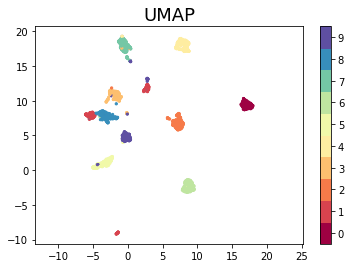

In [7]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP', fontsize=18);

Split dos dados entre treino e teste mantendo 90% para treino e 10% para testes

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

__1º modelo supervisionado: Regressão Logística__

Implementação do modelo de regressão logística utilizando Kfold e cross_validate.

Para o Kfold foi utilizado um fold igual a 5, ou seja, os dados serão particionados em 5 "partes" iguais e em cada uma delas será treinado e validado através dos conjuntos de dados x_train e y_train.

A métrica utilizada como retorno foi a própria acurácia, pois, dado o problema que queremos resolver de classificação de dígitos o que mais nos interesse é se a classificação foi feita correta ou não, e também, pelo fato dos dados serem balanceados não há problemas em utilizar a acurácia.

In [9]:
from sklearn.linear_model import LogisticRegression

KFold = KFold(n_splits=5)

model_lr = LogisticRegression(solver='liblinear')
result_lr = cross_validate(model_lr, X_train, y_train, cv=KFold, scoring='accuracy', return_train_score=True)
    
print('Acurácia - Base de Treino:',result_lr['train_score'].mean())
print('Acurácia - Base de Validação:',result_lr['test_score'].mean())

Acurácia - Base de Treino: 0.9967531745661754
Acurácia - Base de Validação: 0.9536215265833429


Teste utilizando o StratifiedKfold que é bastante indicado para problemas de classificação, no qual ele mantém a mesma proporção entre as classes nos k folds.

In [10]:
StratKFold = StratifiedKFold(n_splits=5)

model_lr = LogisticRegression(solver='liblinear')
result_lr = cross_validate(model_lr, X_train, y_train, cv=StratKFold, scoring='accuracy', return_train_score=True)
    
print('Acurácia - Base de Treino:',result_lr['train_score'].mean())
print('Acurácia - Base de Validação:',result_lr['test_score'].mean())

Acurácia - Base de Treino: 0.9972168530824043
Acurácia - Base de Validação: 0.9529927760577914


Os resultados das métricas apresentadas tanto na base de treino e quanto na base de validação apresentaram uma boa capacidade de generalização e não há evidências de overfitting ou underfitting. 

Utilização do GridSearchCV para a busca dos melhores hiperparâmetros.

O GridSerachCV testa todas as combinações possíveis de hiperparâmetros e retorna quais alcançaram um melhor score.

Os hiperparâmetros testados para a regressão logística foram:

__C__: o parâmetro de regularização<br>
__penalty__: tipo de penalização l1 (lasso) ou l2 (ridge)

In [11]:
valores_C = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3, 5, 10, 20, 50, 100])
#valores_max_iter = np.array([50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
regularizacao = ['l1','l2']
#valores_grid = {'C':valores_C, 'penalty':regularizacao, 'max_iter':valores_max_iter}
valores_grid = {'C':valores_C, 'penalty':regularizacao}

model_lr = LogisticRegression(solver='liblinear')

grid_model_lr = GridSearchCV(estimator=model_lr, param_grid=valores_grid, scoring='accuracy', cv=5)
grid_model_lr.fit(X_train,y_train)

print('Melhor acuracia:',grid_model_lr.best_score_)
print('C:',grid_model_lr.best_estimator_.C)
print('Penalty:',grid_model_lr.best_estimator_.penalty)

Melhor acuracia: 0.9653613882200054
C: 0.1
Penalty: l1


Treinamento do modelo de regressão logística utilizando os melhores hiperparâmetros encontrados

In [12]:
model_lr = LogisticRegression(solver='liblinear', C=0.1, penalty='l1')
model_lr.fit(X_train,y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

__2º modelo supervisionado: Árvore de Decisão__

Implementação do modelo de árvore de decisão utilizando os mesmos métodos de Kfold e cross_validate e a mesma divisão de 5 folds.

A métrica utilizada como retorno também foi a acurácia pelos mesmos motivos citados no modelo de regressão logística.

In [13]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

KFold = KFold(n_splits=5)

model_dt = DecisionTreeClassifier()
result_dt = cross_validate(model_dt, X_train, y_train, cv=KFold, scoring='accuracy', return_train_score=True)
    
print('Acurácia - Base de Treino:',result_lr['train_score'].mean())
print('Acurácia - Base de Validação:',result_lr['test_score'].mean())

Acurácia - Base de Treino: 0.9972168530824043
Acurácia - Base de Validação: 0.9529927760577914


Teste utilizando o StratifiedKfold que é bastante indicado para problemas de classificação, no qual ele mantém a mesma proporção entre as classes nos k folds.

In [14]:
StratKFold = StratifiedKFold(n_splits=5)

model_dt = DecisionTreeClassifier()
result_dt = cross_validate(model_dt, X_train, y_train, cv=KFold, scoring='accuracy', return_train_score=True)
    
print('Acurácia - Base de Treino:',result_lr['train_score'].mean())
print('Acurácia - Base de Validação:',result_lr['test_score'].mean())

Acurácia - Base de Treino: 0.9972168530824043
Acurácia - Base de Validação: 0.9529927760577914


Para o algoritmo de árvores de decisão os resultados das métricas apresentadas tanto na base de treino e quanto na base de validação também apresentaram uma boa capacidade de generalização e não há evidências de overfitting ou underfitting. 

Utilização do GridSearchCV para a busca dos melhores hiperparâmetros.

Os hiperparâmetros testados para a regressão logística foram:

__min_samples_split___: número de amostras mínimas para considerar um nó para divisão<br>
__max_depth__: profundidade máxima da árvore<br>
__criterion__: medida de qualidade do split para o cálculo de ganho de informação

In [15]:
min_samples = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
max_depth = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
algorit = ['gini','entropy']
valores_grid = {'min_samples_split':min_samples,'max_depth':max_depth,'criterion':algorit}

model_dt = DecisionTreeClassifier()

grid_model_dt = GridSearchCV(estimator=model_dt, param_grid=valores_grid, cv=5, scoring='accuracy')
grid_model_dt.fit(X_train,y_train)

print('Melhor acuracia:',grid_model_dt.best_score_)
print('min_samples_split:',grid_model_dt.best_estimator_.min_samples_split)
print('max_depth:',grid_model_dt.best_estimator_.max_depth)
print('criterion:',grid_model_dt.best_estimator_.criterion)

Melhor acuracia: 0.8602281848411879
min_samples_split: 2
max_depth: 11
criterion: entropy


Treinamento do modelo de árvore de decisão utilizando os melhores hiperparâmetros encontrados

In [16]:
model_dt = DecisionTreeClassifier(min_samples_split=2, max_depth=11, criterion='entropy')
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11)

__Avaliação do melhor modelo__

Após os processos de validação cruzada e também de busca por melhores hiperparâmetros, a conclusão é que a regressão logística apresentou melhores resultados na base de validação.

- Acurácia regressão logística: 0.9653613882200054<br>
- Acurácia árvore de decisão: 0.8627087872185912

Teste do modelo com os dados de teste e plot da matriz de confusão.

Score: 0.9611111111111111


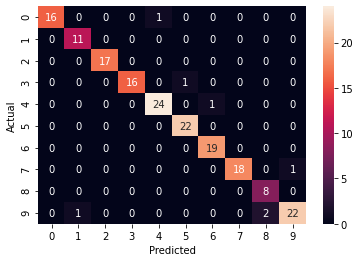

Precision: 0.9539710144927538
Recall: 0.9669721362229102
F1-Score: 0.9586580959189653


In [28]:
from sklearn.metrics import precision_recall_fscore_support

y_pred = model_lr.predict(X_test)
score = model_lr.score(X_test, y_test)
print('Score:',score)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()


p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='macro')

print('Precision:',p)
print('Recall:',r)
print('F1-Score:',f)

Gerando apenas mais uma comparação entre os modelos através da métrica ROC AUC (área abaixo da curva) e nela percebemos que a regressão logística continua obtendo melhores resultados.

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_lr = model_lr.predict_proba(X_test)
y_prob_dt = model_dt.predict_proba(X_test)

macro_roc_auc_ovr_lr = roc_auc_score(y_test, y_prob_lr, multi_class="ovr", average="macro")
macro_roc_auc_ovr_dt = roc_auc_score(y_test, y_prob_dt, multi_class="ovr", average="macro")

print("One-vs-Rest ROC AUC scores (macro) - Regressão Logística:\n",macro_roc_auc_ovr_lr)
print("One-vs-Rest ROC AUC scores (macro) - Árvore de Decisão:\n",macro_roc_auc_ovr_dt)

One-vs-Rest ROC AUC scores (macro) - Regressão Logística:
 0.9994840129309717
One-vs-Rest ROC AUC scores (macro) - Árvore de Decisão:
 0.9450142557200791
